To tutaj sprawdza proste parametry żeby sprawdzić czy skrypt działa dobrze.
Bardziej skomplikowane siatki wrzucać na kaggla po dopasowaniu i dobraniu danych -
trzeba zmienić nazwe pliku tutaj niżej

In [18]:
# nazwy outputów
TITLE = 'bagging.10'

# ścieżka do pliku z danymi
DATA_PATH = '../dataset.reduced.csv'

# ilość kroswalidacji
CROSS_VAL_N = 3

# nazwa pliku csv z wynikami z innych eksperymentów do wykresu punktowego
OTHER_SCORES_CSV_PATERN = 'bagging'

GRID = {
    'regressor__n_estimators': [10],
    'regressor__max_samples': [.001],
    'regressor__max_features': [1.0],
    'regressor__bootstrap': [True],
    'regressor__bootstrap_features': [True],
    'regressor__oob_score': [False],
    'regressor__warm_start': [False],

    'preprocessor__fill_NA_average__imputer__strategy': ['mean', 'median']
}

In [19]:
"""Wczytanie"""
from pandas import read_csv
df = read_csv(DATA_PATH, low_memory=False).drop(columns=[
    'free_month', 'free_year', 
    'district_lat', 'district_lon', 'district_name',
    'city_name'
], axis=1)

X = df.drop('price', axis=1)
y = df['price']
del df

In [20]:
"""Podział"""
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X, y

In [21]:
"""Preproes NA = mediana | 0"""
cat = train.select_dtypes(include='object').columns
fill_NA_average = ['year', 'rooms', 'floor']
fill_NA_0 = ['area_outside', 'rent']
passthrough = [c for c in train.columns if c not in [*fill_NA_average, *fill_NA_0, *cat]]
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
preprocessor = ColumnTransformer(transformers=[    
    ('encode', Pipeline(steps=[('encoder', OneHotEncoder())]), cat),
    ('fill_NA_average', Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]), fill_NA_average),
    ('fill_NA_0', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0))]), fill_NA_0),
    ('passthrough', make_pipeline('passthrough'), passthrough)
])

In [22]:
"""Model"""
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor()))
])

In [23]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(pipeline, GRID, cv=CROSS_VAL_N, scoring='neg_mean_absolute_error', n_jobs=6)
search.fit(train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('encode',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['category', 'market', 'material', 'status', 'type', 'windows'], dtype='object')),
                                                                        ('fill_NA_average',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['year',
                                                                          'rooms',
                                                                          'floor']),
                                                                        ('fill_NA_0'...
             n_jobs=6,
             param_grid={'preprocessor__fill_NA_average__imputer__strategy': ['mean',
                                                                              'median'],
                         'regressor__bootstrap': [True],
                         'regressor__bootstrap_features': [True],
                         'regressor__max_features': [1.0],
                         'regressor__max_samples': [0.001],
                         'regressor__n_estimators': [10],
                         'regressor__oob_score': [False],
                         'regressor__warm_start': [False]},
             scoring='neg_mean_absolute_error')

In [24]:
"""Migawka modelu"""
model = search.best_estimator_
import pickle
with open(f'{TITLE}.pkl', 'wb') as file:
    pickle.dump(model, file)

In [25]:
"""Wyniki innych modeli dla porównania"""
import glob
from pandas import read_csv, concat, DataFrame
cv_scores_other = DataFrame()
for file_name in glob.glob(f'{OTHER_SCORES_CSV_PATERN}.*.csv'):
    cv_scores_other = concat([cv_scores_other, read_csv(file_name)])

In [69]:
from pandas import DataFrame, to_numeric
cv_scores = DataFrame(search.cv_results_).drop('params', axis=1)
cv_scores = cv_scores.apply(to_numeric, errors='coerce')
cv_scores_errored = cv_scores.columns[cv_scores.isnull().any()].tolist()
cv_scores[cv_scores_errored] = DataFrame(search.cv_results_)[cv_scores_errored]
cv_scores.to_csv(f'{TITLE}.csv')
cv_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__fill_NA_average__imputer__strategy,param_regressor__bootstrap,param_regressor__bootstrap_features,param_regressor__max_features,param_regressor__max_samples,param_regressor__n_estimators,param_regressor__oob_score,param_regressor__warm_start,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,54.694391,0.822466,25.772166,0.335100,mean,True,True,1.0,0.001,10,False,False,-140835.690503,-139035.496973,-146853.909225,-142241.698900,3343.106065,1
1,54.280854,1.606469,24.727560,0.638335,median,True,True,1.0,0.001,10,False,False,-141534.741404,-144768.461083,-162240.804682,-149514.669056,9095.058428,2


In [81]:
def scatter_3d(df, 
    x_col, x_title, 
    y_col, y_title, 
    z_col, z_title, 
    size_col, size_title, 
    color_col, color_title, color_scale=None, 
    scatter=0.01
):

    from plotly.graph_objects import Figure, Scatter3d
    from numpy import random, log, mean

    non_numeric_cols = [col for col in df.columns if col.startswith('param_') and df[col].dtype not in ['int64', 'float64']]

    fig = Figure(data=[Scatter3d(
        x=df[x_col] + mean(df[x_col]) * random.normal(0, scatter, size=len(df)),
        y=df[y_col] + mean(df[y_col]) * random.normal(0, scatter, size=len(df)),
        z=df[z_col] + mean(df[z_col]) * random.normal(0, scatter, size=len(df)),
        mode='markers',
        marker=dict(
            size=log(df[size_col]),
            sizemode='diameter',
            sizeref=.1,
            opacity=0.8,
            color=df[color_col],
            colorscale='thermal',
            colorbar=dict(title=color_title),
            cmin=color_scale[0] if color_scale else None,
            cmax=color_scale[1] if color_scale else None
        ),
        text=
            x_title + '=' + df[x_col].astype(str) + '; ' + 
            y_title + '=' + df[y_col].astype(str) + '; ' + 
            z_title + '=' + df[z_col].astype(str) + '; ' +
            ((size_title + '='+ df[size_col].astype(str) + '; ') if size_title else '') + 
            ((color_title + '='+ round(df[color_col],3).astype(str) + '; ') if color_col else '') +
            non_numeric_cols[0] +'=' + df[non_numeric_cols[0]].astype(str) + '; ',
        hoverinfo='text'
    )])

    fig.update_layout(
        title="Parametry i wyniki walidacji krzyżowej",
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title=x_title,
            yaxis_title=y_title,
            zaxis_title=z_title
        )
    )
    
    return fig

In [82]:
from pandas import concat
scatter_3d(concat([cv_scores, cv_scores_other]), 
    'param_regressor__n_estimators', 'liczba drzew',
    'param_regressor__max_features', 'liczba cech',
    'param_regressor__max_samples', 'rozmiar próbki',
    'param_regressor__n_estimators', '',
    'mean_test_score', 'średni wynik walidacji', scatter=0.01
)

In [83]:
"""Predykcje"""
from pandas import Series
pred_train = Series(model.predict(train))
pred_test = Series(model.predict(test))

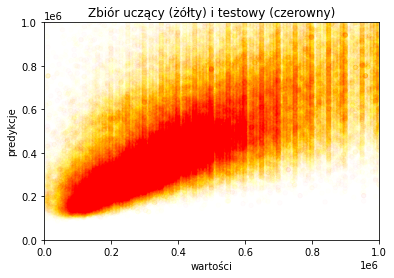

In [30]:
"""Wykres predykcji"""
from pandas import DataFrame, Series
DataFrame({ 'y': [*y_train, *y_test], 'p': [*pred_train, *pred_test]}).plot(
    kind='scatter', 
    title="Zbiór uczący (żółty) i testowy (czerowny)",
    x='y', xlabel='wartości', xlim=(0, pred_test.quantile(.95)),
    y='p', ylabel='predykcje', ylim=(0, pred_test.quantile(.95)),
    c=Series(([0] * len(pred_train) + [1] * len(pred_test))).map({0: 'yellow', 1: 'red'}), 
    alpha=.01
);

In [84]:
"""Punktacja"""
from sklearn import metrics
from numpy import sqrt
from pandas import DataFrame
test_scores = DataFrame({
    'R2': [metrics.r2_score(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'MSE': [metrics.mean_squared_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'RMSE': [sqrt(metrics.mean_squared_error(y_test, pred_test)), metrics.r2_score(y_train, pred_train)],
    'MAE': [metrics.mean_absolute_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'MAPE': [metrics.mean_absolute_percentage_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)]
},  index = ['test', 'train'])

test_scores.to_csv(f'test.{TITLE}.csv')
test_scores

,R2,MSE,RMSE,MAE,MAPE
test,0.019311,6.053899e+12,2.460467e+06,139559.929586,0.361098
train,0.070773,7.077308e-02,7.077308e-02,0.070773,0.070773


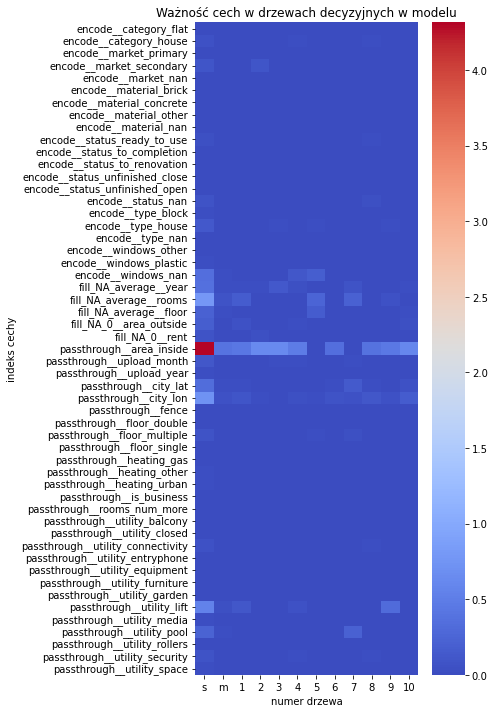

In [86]:
"""Ważność cech"""
def features_heatmap(bagging):
    from pandas import DataFrame
    from seaborn import heatmap
    from matplotlib.pyplot import figure

    names = model.named_steps['preprocessor'].get_feature_names_out()
    trees = bagging.named_steps['regressor'].estimators_

    tree_numbers = [f'{i+1}' for i in range(len(model.named_steps['regressor'].estimators_))]
    importance = DataFrame(index=names, columns=tree_numbers)
    for i_tree in range(len(trees)):
        
        tree = bagging.named_steps['regressor'].estimators_[i_tree]
        f_indices = bagging.named_steps['regressor'].estimators_features_[i_tree]
        
        importance.iloc[f_indices, i_tree] = tree.feature_importances_
        
    importance = importance.infer_objects(copy=False).fillna(0)
    importance['m'] = importance.mean(axis=1)
    importance['s'] = importance.sum(axis=1)
    importance = importance[['s', 'm'] + [col for col in importance if col not in ['m', 's']]]


    figure(figsize=(5, 12))
    ax = heatmap(importance, cmap='coolwarm')
    ax.set_ylabel('indeks cechy')
    ax.set_xlabel('numer drzewa')
    ax.set_title('Ważność cech w drzewach decyzyjnych w modelu')

    return importance

f_imp = features_heatmap(model)

In [87]:
"""Cechy średnio nieistotne"""
[x.split('__')[1] for x in f_imp[f_imp['m'].round(2) == 0.0]['s'].index]

['category_flat',
 'market_primary',
 'market_nan',
 'material_brick',
 'material_concrete',
 'material_other',
 'material_nan',
 'status_ready_to_use',
 'status_to_completion',
 'status_to_renovation',
 'status_unfinished_close',
 'status_unfinished_open',
 'type_block',
 'type_nan',
 'windows_other',
 'windows_plastic',
 'upload_year',
 'fence',
 'floor_double',
 'floor_single',
 'heating_gas',
 'heating_other',
 'heating_urban',
 'is_business',
 'rooms_num_more',
 'utility_balcony',
 'utility_closed',
 'utility_connectivity',
 'utility_entryphone',
 'utility_equipment',
 'utility_furniture',
 'utility_garden',
 'utility_media',
 'utility_rollers',
 'utility_space']

In [88]:
"""Cechy sumarycznie nieistotne"""
[x.split('__')[1] for x in f_imp[f_imp['s'].round(2) == 0.0]['s'].index]

['market_nan',
 'material_concrete',
 'status_unfinished_close',
 'status_unfinished_open',
 'is_business',
 'rooms_num_more',
 'utility_entryphone']